In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mpl_toolkits.mplot3d import Axes3D

from simulation import minimal_model as mm
from surrogate import neural_network

from sampling.grid import Grid
from sampling.random import Random
from sampling.lhs import LatinHyperCube, OrtogonalLatinHyperCube
from sampling.greedy_farpoint import GREEDYFP

from visualise import stream, surface

from skgstat import Variogram, OrdinaryKriging

2024-06-17 18:10:36.099608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 18:10:36.897760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_primes(n):
    out = list()
    sieve = [True] * (n+1)
    for p in range(2, n+1):
        if (sieve[p] and sieve[p]%2==1):
            out.append(p)
            for i in range(p, n+1, p):
                sieve[i] = False
    return out

In [678]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

requested_n = 1000
prime = get_primes(int(np.sqrt(requested_n)))[-1]
n_samples = prime**2

# Minimal model testing
g = 1.79
B_lim, D_lim = 2.9, 0.4
bounds = [(0, D_lim), (0, B_lim)]
n_samples

961

In [4]:
# Define the variogram model (simple linear model)
def variogram(x, y):
    return np.linalg.norm(x - y)

# Kriging interpolation function
def kriging_interpolation(points, grid_x, grid_y):
    n = points.shape[0]
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)
    
    # Construct the A matrix using variogram values between known points
    for i in range(n):
        for j in range(n):
            A[i, j] = variogram(points[i, :2], points[j, :2])
        A[i, n] = 1  # Adding the constraint
        A[n, i] = 1  # Adding the constraint
    
    A[n, n] = 0  # Regularization term

    Z = points[:, 2]
    
    interpolated_values = np.zeros_like(grid_x)
    
    # Iterate over each grid point
    for gx in range(grid_x.shape[0]):
        for gy in range(grid_x.shape[1]):
            # Construct the b vector using variogram values between grid point and known points
            for i in range(n):
                b[i] = variogram([grid_x[gx, gy], grid_y[gx, gy]], points[i, :2])
            b[n] = 1  # Adding the constraint
            
            # Solve the linear system to get weights
            weights = np.linalg.solve(A, b)
            
            # Calculate the interpolated value using the weights
            interpolated_values[gx, gy] = np.dot(weights[:-1], Z)
    
    return interpolated_values

In [807]:
def create_pdf_from_grid(grid_z, **kwargs):
    # All negatives to positive and invert valus. This will benefit values closer to 0 (equilibrium)
    grid_z = np.abs(grid_z) *  -1

    # Normalize the grid values to create a PDF
    min_val = np.min(grid_z)
    
    # Invert and normalize to make regions near zero have higher probabilities
    inverted_grid_z = min_val - grid_z
    pdf = inverted_grid_z / np.sum(inverted_grid_z)
    # Add negative zero
    return pdf

def create_pdf_from_grid_exp(grid_z, beta=1.0):
    # Ensure grid_z has only non-negative values by taking absolute values
    grid_z = np.abs(grid_z)
    
    # Normalize the grid values to the range [0, 1]
    min_val = np.min(grid_z)
    max_val = np.max(grid_z)
    normalized_grid_z = (grid_z - min_val) / (max_val - min_val)
    
    # Apply the exponential function to emphasize closeness to zero
    exp_grid_z = np.exp(-beta * normalized_grid_z)
    
    # Normalize to create a proper probability density function
    pdf = exp_grid_z / np.sum(exp_grid_z)
    
    return pdf

def create_pdf_from_grid_log(grid_z):
    # Ensure grid_z has only non-negative values by taking absolute values
    normalized_grid_z = np.abs(grid_z)
    
    # Normalize the grid values to the range [0, 1]
    min_val = np.min(grid_z)
    max_val = np.max(grid_z)
    # normalized_grid_z = (grid_z - min_val) / (max_val - min_val)
    print(normalized_grid_z.min(), normalized_grid_z.max())
    # Add a small constant to avoid log(0) which is undefined
    print(np.where(normalized_grid_z == 0))
    normalized_grid_z[normalized_grid_z == 0] += 1e-10
    
    # Apply the logarithmic function to emphasize closeness to zero
    log_grid_z = np.log(normalized_grid_z)
    
    # Invert the values to ensure that values closer to zero have higher probabilities
    inverted_log_grid_z = -log_grid_z
    
    # Normalize the inverted log values to the range [0, 1]
    min_inverted_log_val = np.min(inverted_log_grid_z)
    max_inverted_log_val = np.max(inverted_log_grid_z)
    scaled_inverted_log_grid_z = (inverted_log_grid_z - min_inverted_log_val) / (max_inverted_log_val - min_inverted_log_val)
    
    # Create the PDF by normalizing the scaled inverted log values to sum to 1
    pdf = scaled_inverted_log_grid_z / np.sum(scaled_inverted_log_grid_z)
    
    return pdf

# Example run

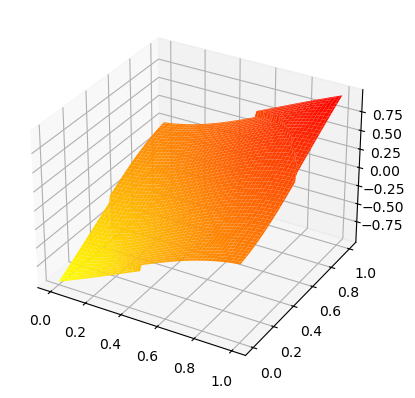

1.0000000000000002


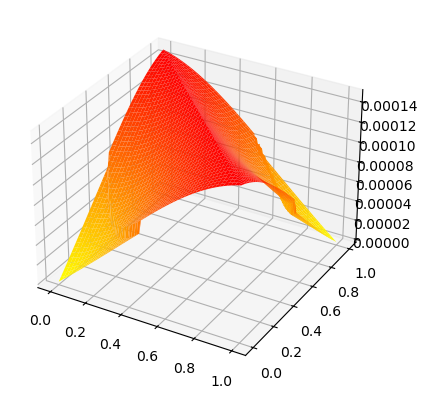

0.0 0.9986111507620133
1.0


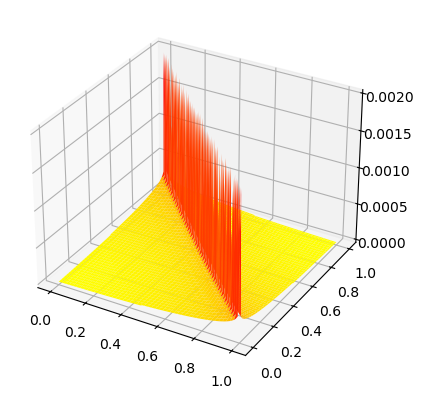

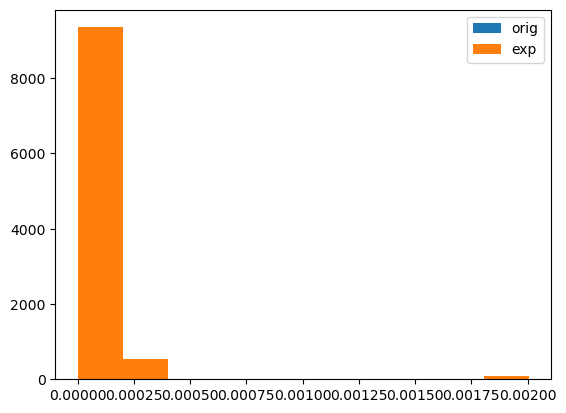

In [739]:
# Sample data points (x, y, z)
straight_slope = np.array([
    [0, 0, -1],
    [0, 1, -1],

    [0.5, 0, 0],
    [0.5, 1, 0],

    [1, 0, 1],
    [1, 1, 1]
])

# Sample data points (x, y, z)
diagonal_slope = np.array([
    [0, 0, -1],
    [0, 1, 0],

    [1, 0, 0],
    [1, 1, 1]
])

test_points = diagonal_slope

# Define grid
B_grid, D_grid = np.mgrid[0:1:100j, 0:1:100j]
V = Variogram(test_points[:,:2], test_points[:,2], n_lags=10, model='spherical', normalize=False)
ok = OrdinaryKriging(V, min_points=1, max_points=50, mode='estimate')
dD_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(B_grid, D_grid, dD_dt, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

test_pdf = create_pdf_from_grid(dD_dt)
print(test_pdf.sum())
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(B_grid, D_grid, test_pdf, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

test_pdf_exp = create_pdf_from_grid_log(dD_dt)
print(test_pdf_exp.sum())
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(B_grid, D_grid, test_pdf_exp, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

plt.hist(test_pdf.flatten(), label='orig')
plt.hist(test_pdf_exp.flatten(), label='exp')
plt.legend()
plt.show()

In [650]:
test_pdf_exp.min()

0.0

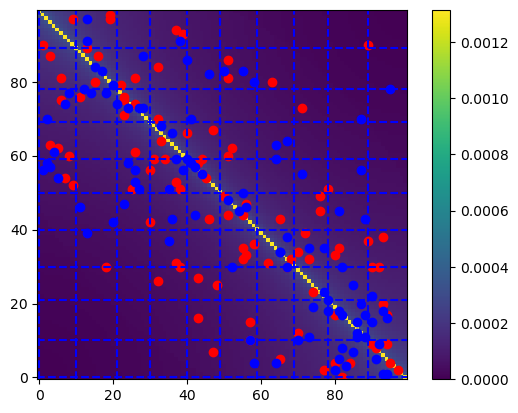

In [651]:
x_random, y_random = Random.sample_stack_pdf(bounds, 100, test_pdf_exp)
x_lhs, y_lhs = Random.sample_stack_pdf(bounds, 100, test_pdf_exp)

# Calculate the scaling factors based on the bounds and the grid dimensions
test_scale = [test_pdf_exp.shape[0] / bounds[0][1], test_pdf_exp.shape[1] / bounds[1][1]]

# B_scale = [1, 1]
# D_scale = [1, 1]

strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(test_pdf_exp, 10)

# Plot vertical lines for strata_indices_x
for x in strata_indices_x:
    plt.axhline(y=x, color='blue', linestyle='--')

# Plot horizontal lines for strata_indices_y
for y in strata_indices_y:
    plt.axvline(x=y, color='blue', linestyle='--')

plt.scatter(x_random * test_scale[0], y_random * test_scale[1], color='red')
plt.scatter(x_lhs * test_scale[0], y_lhs * test_scale[1], color='blue')
plt.imshow(test_pdf_exp, origin='lower')
plt.colorbar()
plt.show()

# True run

## Generating samples

In [662]:
grid = np.mgrid[0:B_lim:100j, 0:D_lim:100j]
grid.shape

(2, 100, 100)

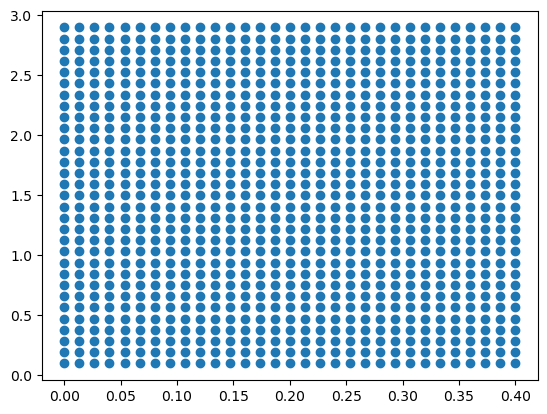

In [873]:
# D_true, B_true = OrtogonalLatinHyperCube.sample_stack([(0, D_lim), (0, B_lim)], n_samples)
D_true, B_true = Grid.sample_stack([(0, D_lim), (1e-1, B_lim)], n_samples)
plt.scatter(D_true, B_true)
plt.show()
dB_dt, dD_dt = mm.step(B_true, D_true, g, warm_up=0)
dB_dt, dD_dt = dB_dt.reshape((prime,prime)), dD_dt.reshape((prime,prime))

dB_dt[0] = dB_dt[1]

points_B = np.column_stack((B_true.flatten(), D_true.flatten(), dB_dt.flatten()))
points_D = np.column_stack((B_true.flatten(), D_true.flatten(), dD_dt.flatten()))

B_grid, D_grid = np.mgrid[0:B_lim:100j, 0:D_lim:100j]

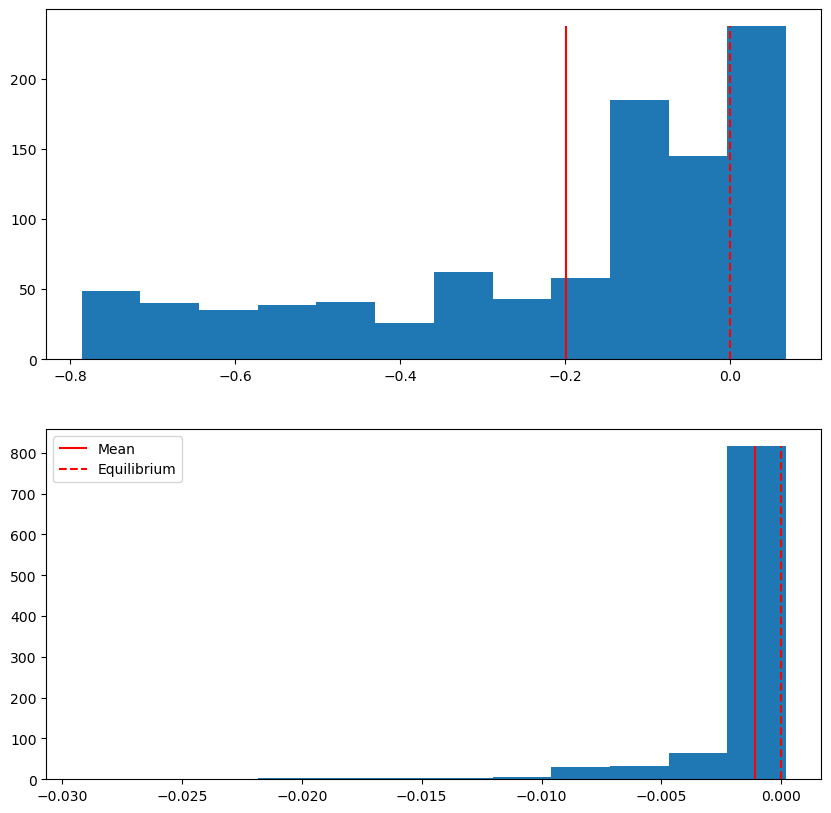

In [874]:
n_bins = 12
fix, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

n_x, bins_x, _ = ax1.hist(dB_dt.flatten(), n_bins, cumulative=False)
ax1.vlines(dB_dt.mean(), ymin=0, ymax=n_x.max(), colors='red', label="Mean")
ax1.vlines(0, ymin=0, ymax=n_x.max(), colors='red', label="Equilibrium", linestyle='dashed')

n_y, bins_y, _ = ax2.hist(dD_dt.flatten(), n_bins, cumulative=False)
ax2.vlines(dD_dt.mean(), ymin=0, ymax=n_y.max(), colors='red', label="Mean")
ax2.vlines(0, ymin=0, ymax=n_y.max(), colors='red', label="Equilibrium", linestyle='dashed')

plt.legend()
plt.show()

# n, bins, patches = plt.hist(dB_dt.flatten(), equalObs(dB_dt.flatten(), 30), edgecolor='black')
# # plt.xscale('log')
# plt.show()

# n, bins, patches = plt.hist(dD_dt.flatten(), equalObs(dD_dt.flatten(), 30), edgecolor='black')
# plt.xscale('log')
# plt.show()
# sorted(bins)

## Exploitation

### Rate of change - D & B

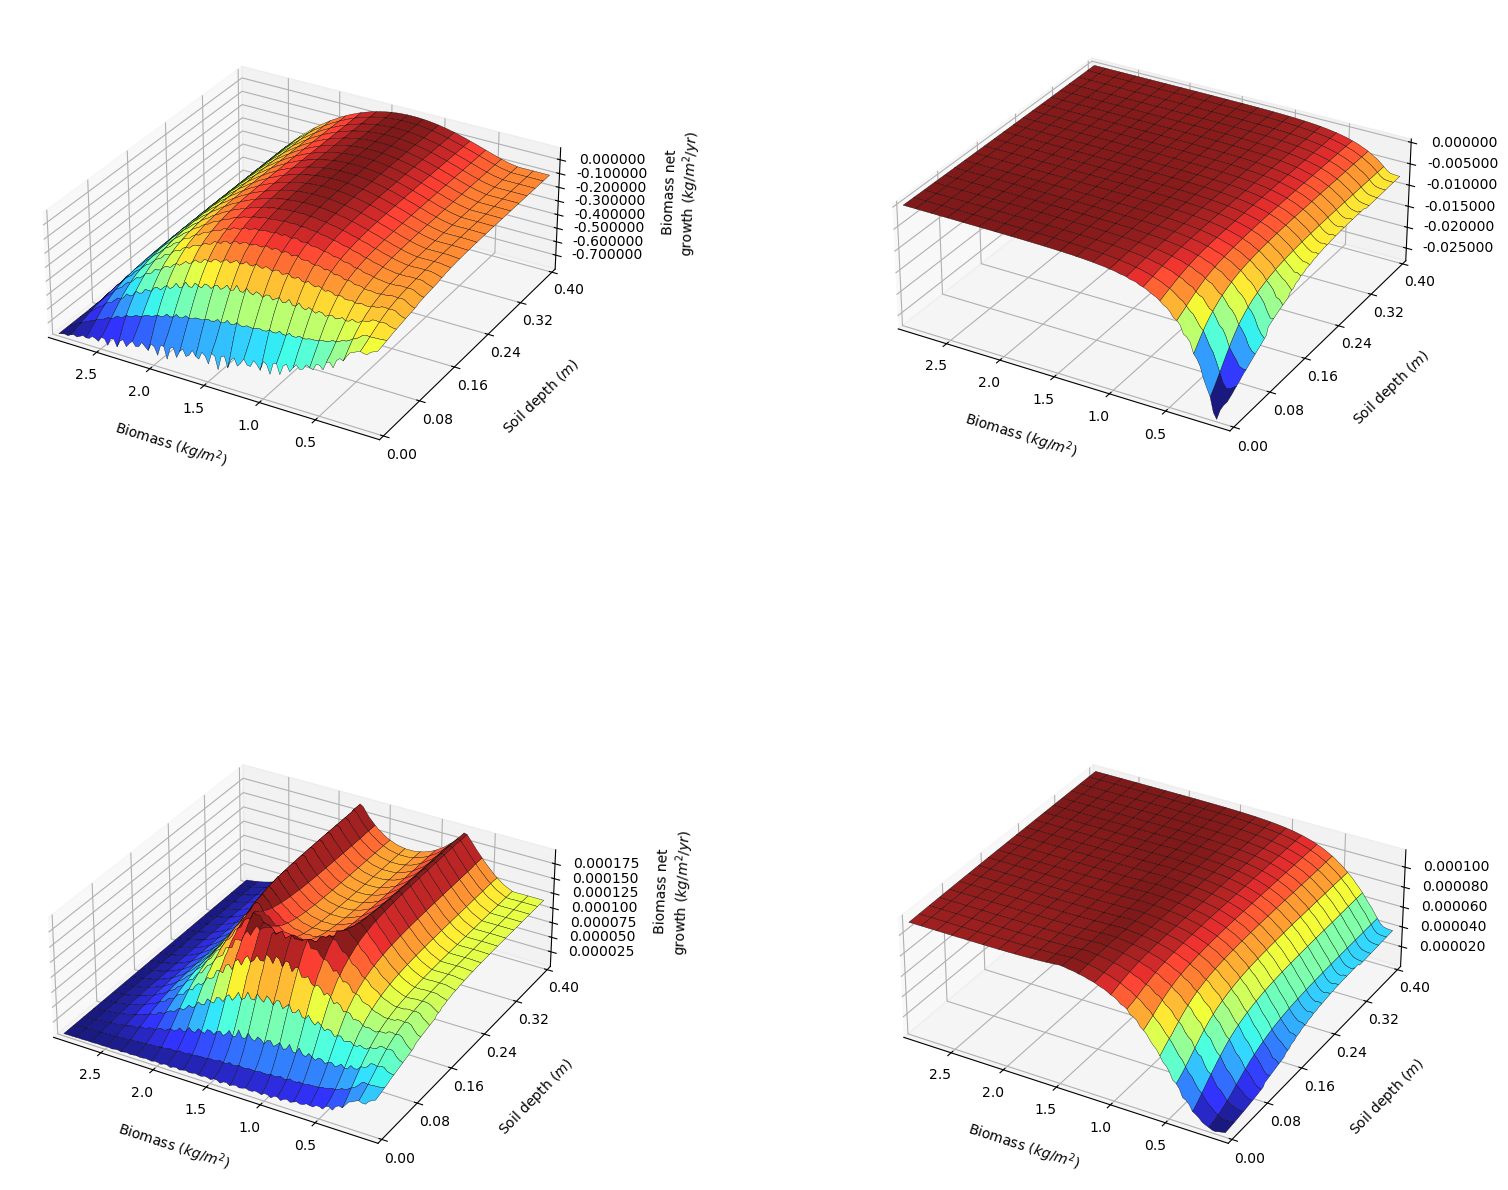

In [875]:
beta = 4
# Define grid
D_vario = Variogram(points_D[:,:2], points_D[:,2], n_lags=20, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(D_vario, min_points=5, max_points=20, mode='exact')
dD_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
# D_pdf = create_pdf_from_grid(dD_dt, beta=beta)
D_pdf = create_pdf_from_grid_exp(dD_dt, beta=beta)

B_vario = Variogram(points_B[:,:2], points_B[:,2], n_lags=20, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(B_vario, min_points=5, max_points=20, mode='exact')
dB_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
# B_pdf = create_pdf_from_grid(dB_dt, beta=beta)
B_pdf = create_pdf_from_grid_exp(dB_dt, beta=beta)

surface.pdf(D_grid, B_grid, dD_dt, dB_dt, D_pdf, B_pdf, D_lim, B_lim)

5.2335659332143833e-11 0.027473193438339368
(array([], dtype=int64), array([], dtype=int64))
2.580294840751464e-05 0.7865151515151522
(array([], dtype=int64), array([], dtype=int64))


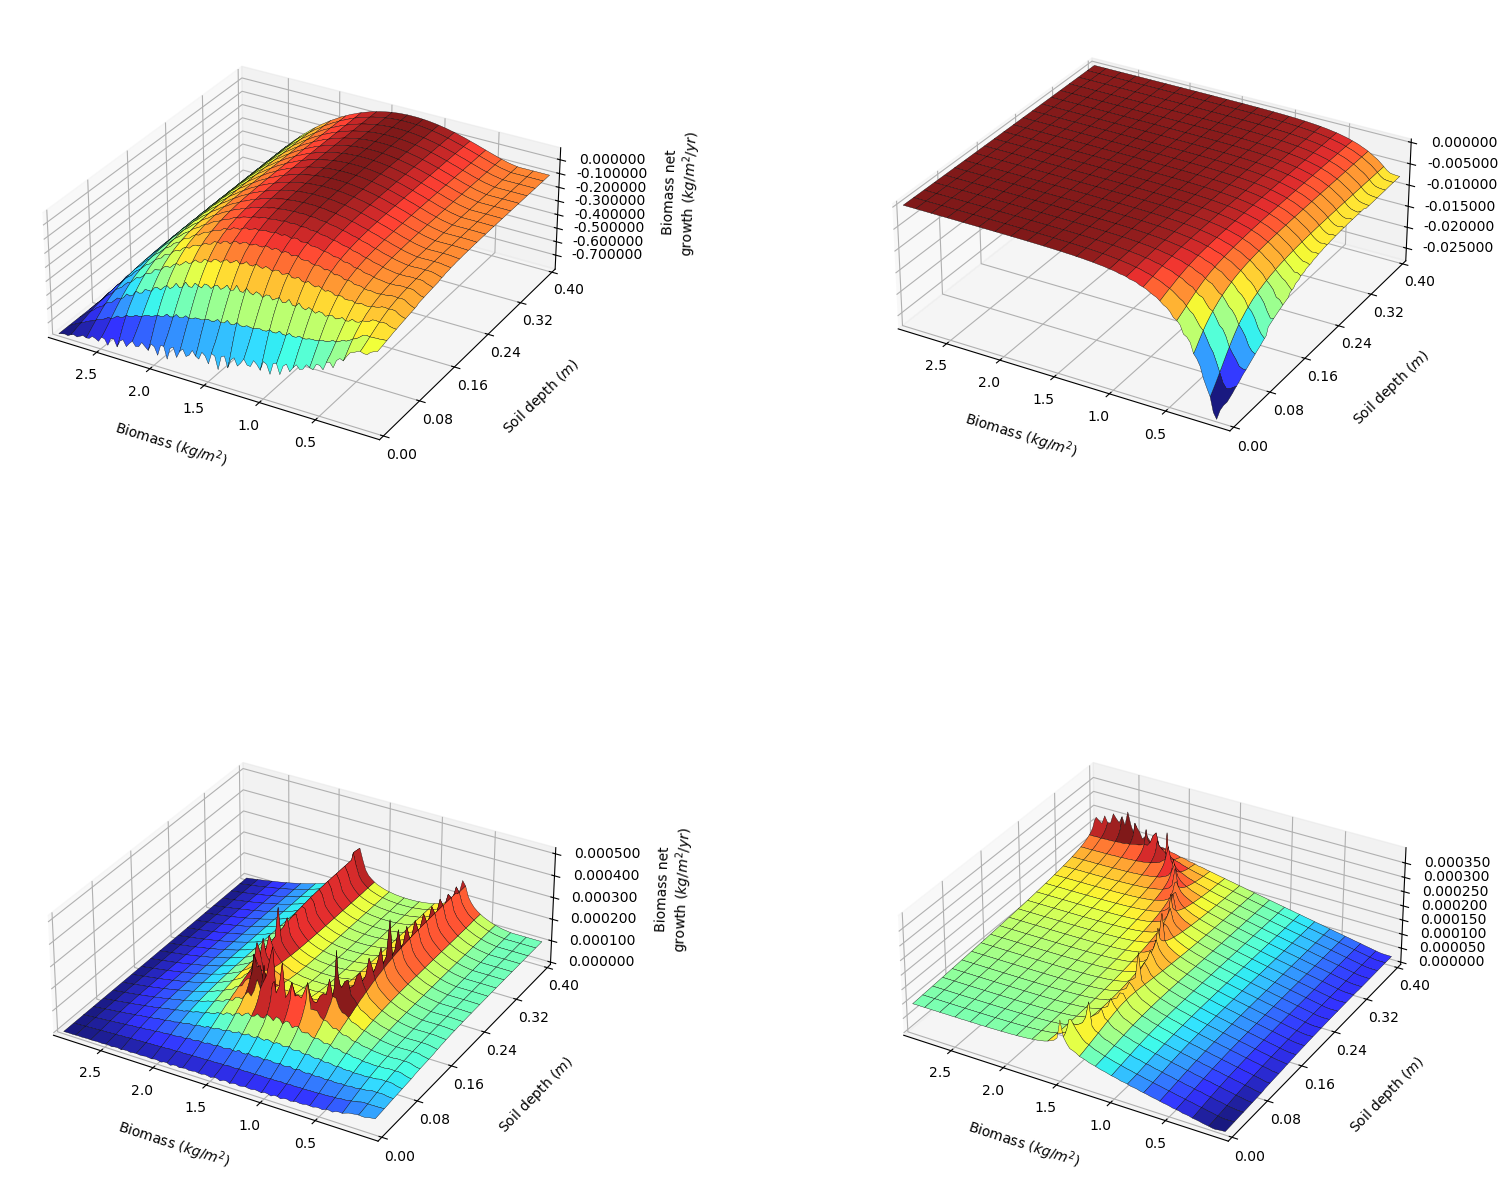

In [876]:
# Define grid
D_vario = Variogram(points_D[:,:2], points_D[:,2], n_lags=20, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(D_vario, min_points=5, max_points=20, mode='exact')
dD_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
# D_pdf = create_pdf_from_grid(dD_dt, beta=beta)
D_pdf = create_pdf_from_grid_log(dD_dt)

B_vario = Variogram(points_B[:,:2], points_B[:,2], n_lags=20, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(B_vario, min_points=5, max_points=20, mode='exact')
dB_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)

# B_pdf = create_pdf_from_grid(dB_dt, beta=beta)
B_pdf = create_pdf_from_grid_log(dB_dt)

sum_pdf = B_pdf + D_pdf
sum_pdf = sum_pdf / np.sum(sum_pdf)

surface.pdf(D_grid, B_grid, dD_dt, dB_dt, D_pdf, B_pdf, D_lim, B_lim)

0.0058659350050886076 0.39974005236398674 0.0035716095079855637 2.8632196315106317


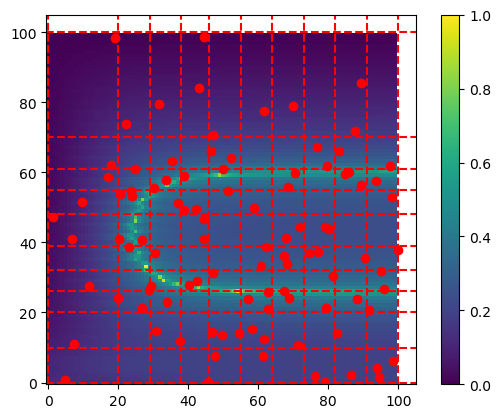

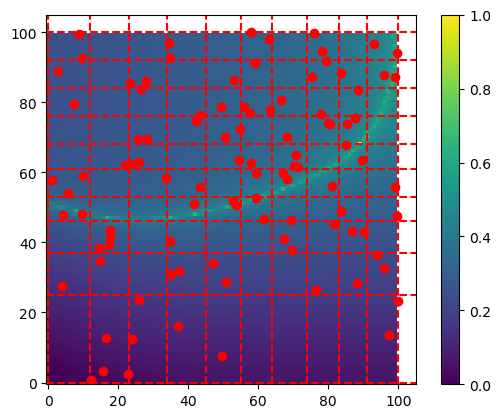

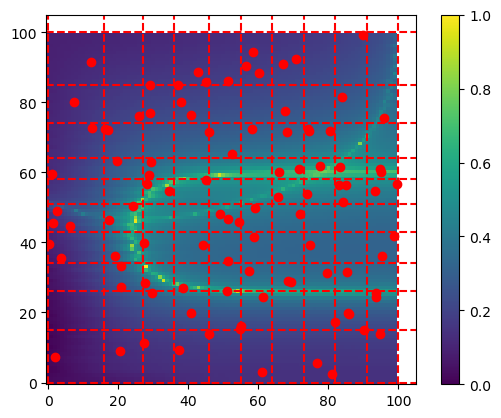

In [886]:
B_samples = LatinHyperCube.sample_stack_pdf(bounds, 100, B_pdf)
D_samples = LatinHyperCube.sample_stack_pdf(bounds, 100, D_pdf)
sum_samples = LatinHyperCube.sample_stack_pdf(bounds, 100, sum_pdf)

print(B_samples[0].min(), B_samples[0].max(), B_samples[1].min(), B_samples[1].max())
strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(B_pdf, 10)

# B_samples = Random.random_pdf(bounds, 100, B_pdf)
# D_samples = Random.random_pdf(bounds, 100, D_pdf)

# Calculate the scaling factors based on the bounds and the grid dimensions
scale = [B_pdf.shape[0] / bounds[0][1], B_pdf.shape[1] / bounds[1][1]] 
scale = [D_pdf.shape[0] / bounds[0][1], D_pdf.shape[1] / bounds[1][1]]

# B_scale = [1, 1]
# D_scale = [1, 1]

# Plot vertical lines for strata_indices_x
for x in strata_indices_x:
    plt.axvline(x=x, color='red', linestyle='--')

# Plot horizontal lines for strata_indices_y
for y in strata_indices_y:
    plt.axhline(y=y, color='red', linestyle='--')

plt.imshow(B_pdf, origin='lower')
plt.scatter(B_samples[0] * scale[0], B_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(D_pdf, 10)

for x in strata_indices_x:
    plt.axvline(x=x, color='red', linestyle='--')

# Plot horizontal lines for strata_indices_y
for y in strata_indices_y:
    plt.axhline(y=y, color='red', linestyle='--')

plt.imshow(D_pdf, origin='lower')
plt.scatter(D_samples[0] * scale[0], D_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(sum_pdf, 10)
for x in strata_indices_x:
    plt.axvline(x=x, color='red', linestyle='--')

# Plot horizontal lines for strata_indices_y
for y in strata_indices_y:
    plt.axhline(y=y, color='red', linestyle='--')

plt.imshow(sum_pdf, origin='lower')
plt.scatter(sum_samples[0] * scale[0], sum_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

0.024000000000000004 0.396 0.0 2.5229999999999997


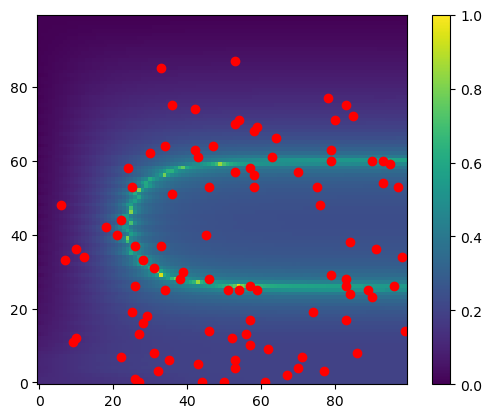

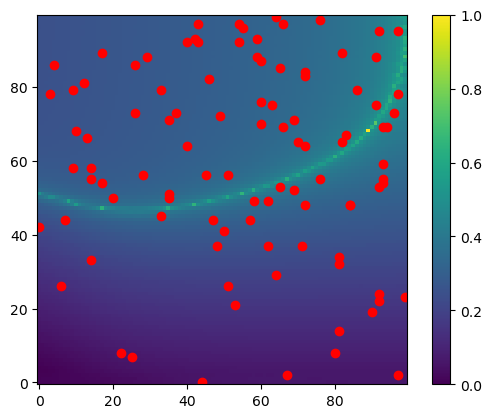

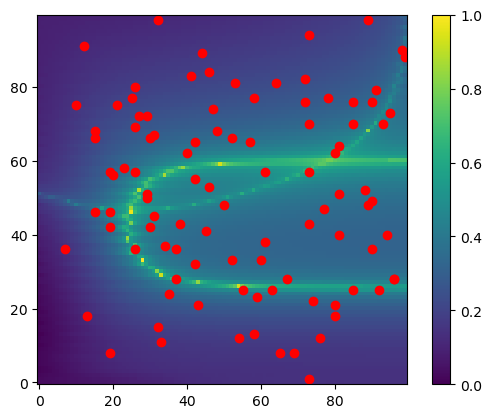

In [894]:
B_samples = Random.sample_stack_pdf(bounds, 100, B_pdf)
D_samples = Random.sample_stack_pdf(bounds, 100, D_pdf)
sum_samples = Random.sample_stack_pdf(bounds, 100, sum_pdf)

print(B_samples[0].min(), B_samples[0].max(), B_samples[1].min(), B_samples[1].max())

# Calculate the scaling factors based on the bounds and the grid dimensions
scale = [D_pdf.shape[0] / bounds[0][1], D_pdf.shape[1] / bounds[1][1]]

# B_scale = [1, 1]
# D_scale = [1, 1]
plt.imshow(B_pdf, origin='lower')
plt.scatter(B_samples[0] * scale[0], B_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

plt.imshow(D_pdf, origin='lower')
plt.scatter(D_samples[0] * scale[0], D_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

plt.imshow(sum_pdf, origin='lower')
plt.scatter(sum_samples[0] * scale[0], sum_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

# Exploitation

In [973]:
def exploit(exploration_methods, exploitation_methods, n_requested_samples, ranges, g, hyper_parameters, folds = 10):
    random_state = 12345

    results = pd.DataFrame(columns=[
        'exploration_method', 'exploitation_method', 'n_explore', 'n_exploit',
        'mse_run', 'mse_method', 'mae_run', 'mae_method',
        'hp', 'uid', 'epochs', 'fold'
    ])

    # Converting requested sizes of N to a list of fitting squares of primes.
    req_sqrt = [int(np.sqrt(n)) for n in n_requested_samples]
    primes = [get_primes(sq)[-1] for sq in req_sqrt]
    n_total_samples = np.array([prime**2 for prime in primes])
    n_explore_samples = np.array([tot//2 for tot in n_total_samples])
    n_exploit_samples = n_total_samples - n_explore_samples

    # Interpolation grid for kriging
    B_grid, D_grid = np.mgrid[0:1:100j, 0:1:100j] 

    # Generating seperate run evaluation set. 
    n_eval = 10**4
    D_true, B_true = Random.sample_stack(ranges, n_eval)
    true_dB_dt, true_dD_dt = mm.step(B_true, D_true, g, warm_up=0)
    # The same across all current experiments
    X_test = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (n_eval))))
    y_test = np.column_stack((true_dB_dt.flatten(), true_dD_dt.flatten()))

    for method_explore in exploration_methods:
        method_explore_name = str(method_explore.__name__)

        for method_exploit in exploitation_methods:
            exploration_method_name = str(method_exploit.__name__)

            for n_explore, n_exploit in list(zip(n_explore_samples, n_exploit_samples)):
                refresh_max = int(n_explore/10) if int(n_explore/10) > 5 else 5

                # Run the combination N times and retrain per size N
                for fold in range(folds):
                    # Exploration sample.
                    D_points, B_points = method_explore.sample_stack(ranges, n_explore, random_state=random_state, refresh_count=refresh_max, scale=2)
                    dB_dt_explore, dD_dt_explore = mm.step(B_points, D_points, g)
                    
                    X_explore = np.column_stack([B_points.flatten(), D_points.flatten(), np.repeat(g, (n_explore))])
                    y_explore = np.column_stack([dB_dt_explore.flatten(), dD_dt_explore.flatten()])

                    # Exploitation
                    ## D Kriging
                    D_vario = Variogram(X_explore[:,:2], y_explore[:,0], n_lags=20, maxlag=2, model='exponential', normalize=False)
                    ok = OrdinaryKriging(D_vario, min_points=5, max_points=20, mode='exact')
                    dD_dt_kriging = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
                    D_pdf = create_pdf_from_grid_exp(dD_dt_kriging, beta=beta)

                    ## B Kriging
                    B_vario = Variogram(X_explore[:,:2], y_explore[:,1], n_lags=20, maxlag=2, model='exponential', normalize=False)
                    ok = OrdinaryKriging(B_vario, min_points=5, max_points=20, mode='exact')
                    dB_dt_kriging = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
                    B_pdf = create_pdf_from_grid_exp(dB_dt_kriging, beta=beta)

                    # Sample based on both pdf
                    # Currently sample twice from both pdf. Combination can be made of pdf's.
                    D_points_B_pdf, B_points_B_pdf = method_exploit.sample_stack_pdf(ranges, n_exploit//2, B_pdf)
                    D_points_D_pdf, B_points_D_pdf = method_exploit.sample_stack_pdf(ranges, n_exploit//2, D_pdf)
                    D_points_exploit, B_points_exploit = np.column_stack([D_points_B_pdf, D_points_D_pdf]), np.column_stack([B_points_B_pdf, B_points_D_pdf])

                    # print(D_points_exploit.shape, B_points_exploit.shape)

                    X_exploit = np.column_stack([D_points_exploit.flatten(), B_points_exploit.flatten(), np.repeat(g, ((n_exploit//2)*2))])
                    # print(X_exploit)
                    dB_dt_exploit, dD_dt_exploit = mm.step(X_exploit[:,0], X_exploit[:,1], g)
                    y_exploit = np.column_stack([dB_dt_exploit.flatten(), dD_dt_exploit.flatten()])

                    # print(X_explore.shape, X_exploit.shape)
                    # print(y_explore.shape, y_exploit.shape)

                    X = np.concatenate([X_explore, X_exploit])
                    y = np.concatenate([y_explore, y_exploit])

                    # print(X.shape, y.shape)

                    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=random_state)
                    NN = neural_network.NeuralNetwork(hyper_parameters)
                    NN.train(X_train, y_train, X_val, y_val, verbose=False)

                    y_true_pred = NN.predict(X_test)
                    y_val_pred = NN.predict(X_val)


                    new_row = pd.DataFrame([{
                        'exploration_method': method_explore_name,
                        'exploitation_method': exploration_method_name,
                        'n': n_exploit + n_explore,
                        'mse_run': mean_squared_error(y_test, y_true_pred), # Unseen large random dataset.
                        'mse_method': mean_squared_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                        'mae_run': mean_absolute_error(y_test, y_true_pred), # Unseen large random dataset.
                        'mae_method': mean_absolute_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                        'hp': hyper_parameters,
                        'uid': NN.uid,
                        'epochs': len(NN.history.history['loss']),
                        'fold': fold
                    }])
                    results = pd.concat([results, new_row], ignore_index=True)

    return results

In [974]:
hp = {
    'units': [256, 256, 256, 128, 64],
    'act_fun': 'relu',
    'learning_rate': 0.005,
    'batch_size': 32,
    'l2_reg': 1e-4,
    'n_epochs': 400}

n_requested_samples = [25, 50, 121, 200, 529, 1849]
exploration_methods = [LatinHyperCube, GREEDYFP]
exploitation_methods = [LatinHyperCube, Random]

results = exploit(exploration_methods, exploitation_methods, n_requested_samples, bounds, g, hp, folds = 3)

NN training time: 0.209 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/tmp/ipykernel_3979330/2423324946.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


NN training time: 0.246 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


KeyboardInterrupt: 

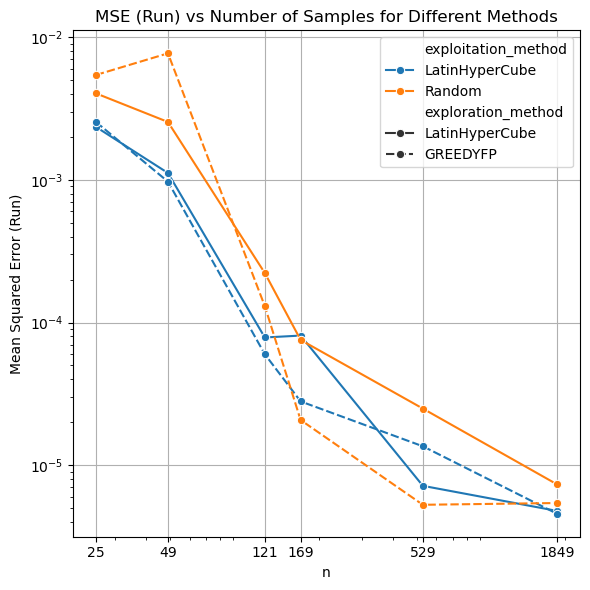

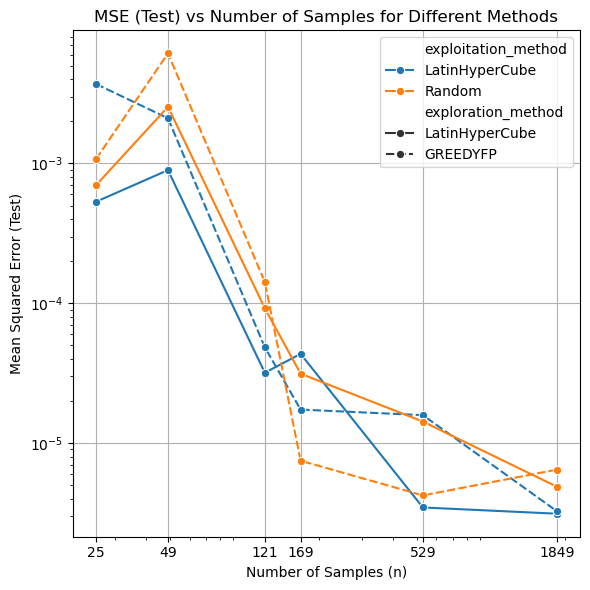

In [946]:
def plot_results_seaborn(results):
    # Create a new figure with two subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(6,6), sharex=True)
    # Plot the first lineplot on the first axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax1)
    sns.lineplot(data=results, x='n', y='mse_run', hue='exploitation_method', marker='o', style="exploration_method", err_style="bars", errorbar=("se"), ax=ax1)
    ax1.set_ylabel('Mean Squared Error (Run)')
    ax1.set_title('MSE (Run) vs Number of Samples for Different Methods')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.grid(True)

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()

    fig, ax2 = plt.subplots(1, 1, figsize=(6,6))

    # Plot the second lineplot on the second axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax2)
    sns.lineplot(data=results, x='n', y='mse_method', hue='exploitation_method', marker='o', style="exploration_method", err_style="bars", errorbar=("se"), ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel('Mean Squared Error (Test)')
    ax2.set_title('MSE (Test) vs Number of Samples for Different Methods')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.grid(True)

    # Set the x-ticks to show the exact x-values

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()
plot_results_seaborn(results)

In [947]:
operations = ['min', 'median', 'max', 'std']
operations = ['min', 'median', 'max']
groups = ['n', 'exploration_method', 'exploitation_method']
groups = ['n', 'exploration_method']
agg_cols = ['mse_run', 'mse_method', 'mae_run', 'mae_method']

exploitation_agg = results.groupby(groups)[agg_cols].agg(
    operations
)
exploitation_agg.reset_index(inplace=True)
exploitation_agg['experiment'] = 'exploitation'
exploitation_agg

n exploration_method   mse_run                     mse_method  \
                                  min    median       max        min   
0     25           GREEDYFP  0.002548  0.003989  0.005429   0.001071   
1     25     LatinHyperCube  0.002352  0.003195  0.004039   0.000531   
2     49           GREEDYFP  0.000971  0.004335  0.007699   0.002106   
3     49     LatinHyperCube  0.001117  0.001830  0.002544   0.000896   
4    121           GREEDYFP  0.000060  0.000095  0.000130   0.000048   
5    121     LatinHyperCube  0.000079  0.000150  0.000222   0.000032   
6    169           GREEDYFP  0.000021  0.000024  0.000028   0.000007   
7    169     LatinHyperCube  0.000076  0.000078  0.000081   0.000031   
8    529           GREEDYFP  0.000005  0.000009  0.000014   0.000004   
9    529     LatinHyperCube  0.000007  0.000016  0.000025   0.000003   
10  1849           GREEDYFP  0.000005  0.000005  0.000005   0.000003   
11  1849     LatinHyperCube  0.000005  0.000006  0.000007   0.000003   

                         mae_run                     mae_method            \
      median       max       min    median       max        min    median   
0   0.002388  0.003706  0.018537  0.025864  0.033192   0.015967  0.017339   
1   0.000614  0.000696  0.021894  0.025468  0.029041   0.011458  0.012559   
2   0.004120  0.006134  0.009589  0.029677  0.049766   0.015297  0.025362   
3   0.001719  0.002542  0.012203  0.015354  0.018506   0.009306  0.011768   
4   0.000095  0.000142  0.002498  0.003100  0.003703   0.002109  0.002872   
5   0.000062  0.000092  0.002721  0.003545  0.004370   0.001524  0.002061   
6   0.000012  0.000017  0.001805  0.001953  0.002102   0.001126  0.001389   
7   0.000037  0.000043  0.002708  0.002771  0.002835   0.001557  0.001568   
8   0.000010  0.000016  0.001033  0.001270  0.001508   0.000755  0.001005   
9   0.000009  0.000014  0.001085  0.001568  0.002051   0.000621  0.000913   
10  0.000005  0.000006  0.000927  0.000954  0.000981   0.000629  0.000669   
11  0.000004  0.000005  0.000844  0.000910  0.000977   0.000554  0.000599   

                experiment  
         max                
0   0.018712  exploitation  
1   0.013659  exploitation  
2   0.035428  exploitation  
3   0.014230  exploitation  
4   0.003635  exploitation  
5   0.002598  exploitation  
6   0.001653  exploitation  
7   0.001579  exploitation  
8   0.001255  exploitation  
9   0.001206  exploitation  
10  0.000708  exploitation  
11  0.000645  exploitation

In [948]:
prev = "10-fold_20240612_123717"
df_10 = pd.read_csv(f"data/experiments/exploration/{prev}.csv", index_col='index')

exploration_agg = df_10[df_10['method'].isin(['GREEDYFP', 'LatinHyperCube'])].groupby(['n', 'method'])[agg_cols].agg(
    operations
)
exploration_agg.reset_index(inplace=True)
exploitation_agg.rename(columns={'exploration_method':'method'}, inplace=True)
exploration_agg['experiment'] = 'exploration'
exploration_agg

n          method   mse_run                     mse_method            \
                               min    median       max        min    median   
0     25        GREEDYFP  0.008815  0.029262  0.031066   0.009791  0.051214   
1     25  LatinHyperCube  0.002671  0.005972  0.012263   0.000341  0.001278   
2     49        GREEDYFP  0.000828  0.001592  0.030598   0.000915  0.001947   
3     49  LatinHyperCube  0.004658  0.005174  0.028303   0.002242  0.002598   
4    121        GREEDYFP  0.000042  0.000111  0.000378   0.000095  0.000349   
5    121  LatinHyperCube  0.000090  0.000402  0.001834   0.000016  0.000199   
6    169        GREEDYFP  0.000034  0.000120  0.028919   0.000044  0.000184   
7    169  LatinHyperCube  0.000155  0.000245  0.000481   0.000129  0.000235   
8    529        GREEDYFP  0.000010  0.000015  0.000022   0.000018  0.000040   
9    529  LatinHyperCube  0.000014  0.000038  0.000061   0.000011  0.000022   
10  1849        GREEDYFP  0.000003  0.000003  0.000005   0.000003  0.000003   
11  1849  LatinHyperCube  0.000006  0.000008  0.000119   0.000005  0.000008   

               mae_run                     mae_method                      \
         max       min    median       max        min    median       max   
0   0.054659  0.041219  0.084574  0.086514   0.055199  0.122132  0.125565   
1   0.015069  0.020110  0.038175  0.060238   0.010622  0.022724  0.066108   
2   0.041026  0.013956  0.020492  0.111684   0.017491  0.025169  0.132108   
3   0.036692  0.029856  0.031883  0.087634   0.023518  0.025343  0.094182   
4   0.000790  0.002421  0.003788  0.006888   0.003238  0.006218  0.009052   
5   0.000424  0.003382  0.006747  0.013196   0.001786  0.004919  0.007867   
6   0.028329  0.002194  0.003627  0.086101   0.002862  0.005131  0.093542   
7   0.000460  0.003522  0.004743  0.005766   0.003393  0.005002  0.006866   
8   0.000069  0.001065  0.001320  0.001494   0.001394  0.001907  0.002174   
9   0.000054  0.001236  0.001772  0.002030   0.001191  0.001532  0.002140   
10  0.000005  0.000753  0.000831  0.000981   0.000758  0.000856  0.001023   
11  0.000114  0.000864  0.001002  0.004330   0.000957  0.001094  0.004219   

     experiment  
                 
0   exploration  
1   exploration  
2   exploration  
3   exploration  
4   exploration  
5   exploration  
6   exploration  
7   exploration  
8   exploration  
9   exploration  
10  exploration  
11  exploration

In [949]:
diff = pd.concat([exploration_agg, exploitation_agg])
display(diff)
diff.shape

n          method   mse_run                     mse_method            \
                               min    median       max        min    median   
0     25        GREEDYFP  0.008815  0.029262  0.031066   0.009791  0.051214   
1     25  LatinHyperCube  0.002671  0.005972  0.012263   0.000341  0.001278   
2     49        GREEDYFP  0.000828  0.001592  0.030598   0.000915  0.001947   
3     49  LatinHyperCube  0.004658  0.005174  0.028303   0.002242  0.002598   
4    121        GREEDYFP  0.000042  0.000111  0.000378   0.000095  0.000349   
5    121  LatinHyperCube  0.000090  0.000402  0.001834   0.000016  0.000199   
6    169        GREEDYFP  0.000034  0.000120  0.028919   0.000044  0.000184   
7    169  LatinHyperCube  0.000155  0.000245  0.000481   0.000129  0.000235   
8    529        GREEDYFP  0.000010  0.000015  0.000022   0.000018  0.000040   
9    529  LatinHyperCube  0.000014  0.000038  0.000061   0.000011  0.000022   
10  1849        GREEDYFP  0.000003  0.000003  0.000005   0.000003  0.000003   
11  1849  LatinHyperCube  0.000006  0.000008  0.000119   0.000005  0.000008   
0     25        GREEDYFP  0.002548  0.003989  0.005429   0.001071  0.002388   
1     25  LatinHyperCube  0.002352  0.003195  0.004039   0.000531  0.000614   
2     49        GREEDYFP  0.000971  0.004335  0.007699   0.002106  0.004120   
3     49  LatinHyperCube  0.001117  0.001830  0.002544   0.000896  0.001719   
4    121        GREEDYFP  0.000060  0.000095  0.000130   0.000048  0.000095   
5    121  LatinHyperCube  0.000079  0.000150  0.000222   0.000032  0.000062   
6    169        GREEDYFP  0.000021  0.000024  0.000028   0.000007  0.000012   
7    169  LatinHyperCube  0.000076  0.000078  0.000081   0.000031  0.000037   
8    529        GREEDYFP  0.000005  0.000009  0.000014   0.000004  0.000010   
9    529  LatinHyperCube  0.000007  0.000016  0.000025   0.000003  0.000009   
10  1849        GREEDYFP  0.000005  0.000005  0.000005   0.000003  0.000005   
11  1849  LatinHyperCube  0.000005  0.000006  0.000007   0.000003  0.000004   

               mae_run                     mae_method                      \
         max       min    median       max        min    median       max   
0   0.054659  0.041219  0.084574  0.086514   0.055199  0.122132  0.125565   
1   0.015069  0.020110  0.038175  0.060238   0.010622  0.022724  0.066108   
2   0.041026  0.013956  0.020492  0.111684   0.017491  0.025169  0.132108   
3   0.036692  0.029856  0.031883  0.087634   0.023518  0.025343  0.094182   
4   0.000790  0.002421  0.003788  0.006888   0.003238  0.006218  0.009052   
5   0.000424  0.003382  0.006747  0.013196   0.001786  0.004919  0.007867   
6   0.028329  0.002194  0.003627  0.086101   0.002862  0.005131  0.093542   
7   0.000460  0.003522  0.004743  0.005766   0.003393  0.005002  0.006866   
8   0.000069  0.001065  0.001320  0.001494   0.001394  0.001907  0.002174   
9   0.000054  0.001236  0.001772  0.002030   0.001191  0.001532  0.002140   
10  0.000005  0.000753  0.000831  0.000981   0.000758  0.000856  0.001023   
11  0.000114  0.000864  0.001002  0.004330   0.000957  0.001094  0.004219   
0   0.003706  0.018537  0.025864  0.033192   0.015967  0.017339  0.018712   
1   0.000696  0.021894  0.025468  0.029041   0.011458  0.012559  0.013659   
2   0.006134  0.009589  0.029677  0.049766   0.015297  0.025362  0.035428   
3   0.002542  0.012203  0.015354  0.018506   0.009306  0.011768  0.014230   
4   0.000142  0.002498  0.003100  0.003703   0.002109  0.002872  0.003635   
5   0.000092  0.002721  0.003545  0.004370   0.001524  0.002061  0.002598   
6   0.000017  0.001805  0.001953  0.002102   0.001126  0.001389  0.001653   
7   0.000043  0.002708  0.002771  0.002835   0.001557  0.001568  0.001579   
8   0.000016  0.001033  0.001270  0.001508   0.000755  0.001005  0.001255   
9   0.000014  0.001085  0.001568  0.002051   0.000621  0.000913  0.001206   
10  0.000006  0.000927  0.000954  0.000981   0.000629  0.000669  0.000708   
11  0.000005  0.000844  0.0

(24, 15)

In [950]:
cols = [[name[0]] if name[1] == '' else list(name) for name in diff.columns.to_flat_index()]
cols = ['_'.join(name) for name in cols]
diff.columns = cols
diff

,n,method,mse_run_min,mse_run_median,mse_run_max,mse_method_min,mse_method_median,mse_method_max,mae_run_min,mae_run_median,mae_run_max,mae_method_min,mae_method_median,mae_method_max,experiment
0,25,GREEDYFP,0.008815,0.029262,0.031066,0.009791,0.051214,0.054659,0.041219,0.084574,0.086514,0.055199,0.122132,0.125565,exploration
1,25,LatinHyperCube,0.002671,0.005972,0.012263,0.000341,0.001278,0.015069,0.020110,0.038175,0.060238,0.010622,0.022724,0.066108,exploration
2,49,GREEDYFP,0.000828,0.001592,0.030598,0.000915,0.001947,0.041026,0.013956,0.020492,0.111684,0.017491,0.025169,0.132108,exploration
3,49,LatinHyperCube,0.004658,0.005174,0.028303,0.002242,0.002598,0.036692,0.029856,0.031883,0.087634,0.023518,0.025343,0.094182,exploration
4,121,GREEDYFP,0.000042,0.000111,0.000378,0.000095,0.000349,0.000790,0.002421,0.003788,0.006888,0.003238,0.006218,0.009052,exploration
5,121,LatinHyperCube,0.000090,0.000402,0.001834,0.000016,0.000199,0.000424,0.003382,0.006747,0.013196,0.001786,0.004919,0.007867,exploration
6,169,GREEDYFP,0.000034,0.000120,0.028919,0.000044,0.000184,0.028329,0.002194,0.003627,0.086101,0.002862,0.005131,0.093542,exploration
7,169,LatinHyperCube,0.000155,0.000245,0.000481,0.000129,0.000235,0.000460,0.003522,0.004743,0.005766,0.003393,0.005002,0.006866,exploration
8,529,GREEDYFP,0.000010,0.000015,0.000022,0.000018,0.000040,0.000069,0.001065,0.001320,0.001494,0.001394,0.001907,0.002174,exploration
9,529,LatinHyperCube,0.000014,0.000038,0.000061,0.000011,0.000022,0.000054,0.001236,0.001772,0.002030,0.001191,0.001532,0.002140,exploration


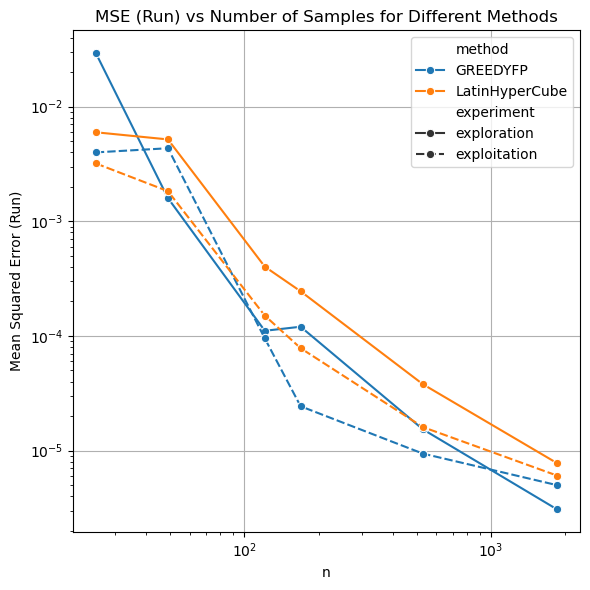

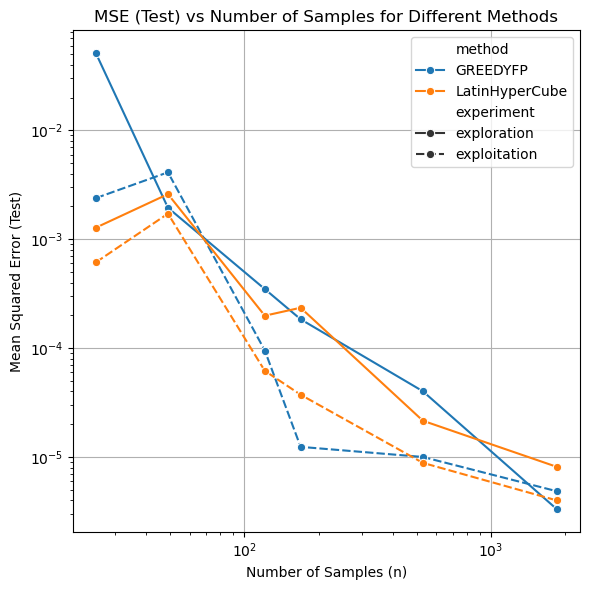

In [951]:
def plot_diff(results):
    # Create a new figure with two subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(6,6), sharex=True)
    # Plot the first lineplot on the first axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax1)
    sns.lineplot(data=results, x='n', y='mse_run_median', hue='method', marker='o', style="experiment", err_style="bars", errorbar=("se"), ax=ax1)
    ax1.set_ylabel('Mean Squared Error (Run)')
    ax1.set_title('MSE (Run) vs Number of Samples for Different Methods')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.grid(True)

    # xticks = sorted(results['n_'].unique())
    # # xticks = np.concatenate([[0], xticks])
    # ax1.set_xticks(xticks)
    # ax1.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()

    fig, ax2 = plt.subplots(1, 1, figsize=(6,6))

    # Plot the second lineplot on the second axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax2)
    sns.lineplot(data=results, x='n', y='mse_method_median', hue='method', marker='o', style="experiment", err_style="bars", errorbar=("se"), ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel('Mean Squared Error (Test)')
    ax2.set_title('MSE (Test) vs Number of Samples for Different Methods')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.grid(True)

    # Set the x-ticks to show the exact x-values

    # xticks = sorted(results['n_'].unique())
    # # xticks = np.concatenate([[0], xticks])
    # ax2.set_xticks(xticks)
    # ax2.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()
plot_diff(diff)

In [952]:
# exploration_agg.reset_index().join(exploitation_agg.reset_index(), rsuffix='_exploit').reset_index()

<Axes: >

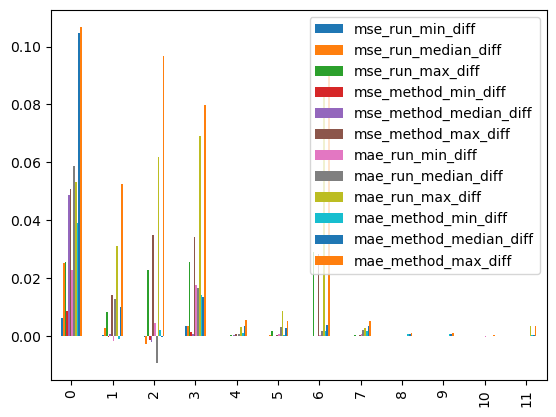

In [953]:
agg_diff = exploration_agg.reset_index()[agg_cols] - exploitation_agg.reset_index().rename(columns={'exploration_method':'method'})[agg_cols]
agg_diff.columns = agg_diff.columns.to_flat_index().str.join('_')
agg_diff = agg_diff.add_suffix('_diff')

agg_diff.plot.bar()

In [954]:
results['n_explore'] = results['n']
results.drop(columns=['n'], inplace=True)
results['n_exploit'] = (results['n_explore'] // 2) * 2
results['n'] = results['n_exploit'] + results['n_explore']
results

,exploration_method,exploitation_method,mse_run,mse_method,mae_run,mae_method,hp,uid,epochs,fold,n_explore,n_exploit,n
index,,,,,,,,,,,,,
0,LatinHyperCube,LatinHyperCube,0.002352,0.000531,0.021894,0.011458,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142207,400,0,25,24,49
1,LatinHyperCube,LatinHyperCube,0.001117,0.000896,0.012203,0.009306,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142230,400,0,49,48,97
2,LatinHyperCube,LatinHyperCube,0.000079,0.000032,0.002721,0.001524,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142253,400,0,121,120,241
3,LatinHyperCube,LatinHyperCube,0.000081,0.000043,0.002835,0.001557,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142319,400,0,169,168,337
4,LatinHyperCube,LatinHyperCube,0.000007,0.000003,0.001085,0.000621,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142347,400,0,529,528,1057
5,LatinHyperCube,LatinHyperCube,0.000005,0.000003,0.000844,0.000554,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142431,400,0,1849,1848,3697
6,LatinHyperCube,Random,0.004039,0.000696,0.029041,0.013659,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142612,400,0,25,24,49
7,LatinHyperCube,Random,0.002544,0.002542,0.018506,0.014230,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142634,400,0,49,48,97
8,LatinHyperCube,Random,0.000222,0.000092,0.004370,0.002598,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240619_142657,400,0,121,120,241


In [955]:
# results.to_csv(f"data/experiments/exploitation/{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index_label="index")